Plot the distribution of GMM

In [2]:
%matplotlib inline
import sys
import os
import copy
import json
from glob import glob

import numpy as np
import pandas as pd
import dill
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo

PYTHONAPI_EGG_PATH = f"{ os.environ['HOME'] }/src/carla/PythonAPI/carla/dist/carla-0.9.11-py3.7-linux-x86_64.egg"
CARLA_COLLECT_PATH = f"{ os.environ['HOME'] }/code/robotics/carla-collect"
sys.path.append('../../../trajectron')
sys.path.append('..')
sys.path.append(PYTHONAPI_EGG_PATH)
sys.path.append(CARLA_COLLECT_PATH)

import utility as util
from helper import load_model, prediction_output_to_trajectories
import visualization
from model.dataset import *
from model.components import *
from model.model_utils import *

from model.components.discrete_latent import DiscreteLatent
from model.components.map_encoder import CNNMapEncoder
from model.dataset.preprocessing import get_node_timestep_data

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'olive', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 3) % len(AGENT_COLORS) for i in range(17)], 0)
NCOLORS = len(AGENT_COLORS)

def node_to_df(node):
    columns = ['_'.join(t) for t in node.data.header]
    return pd.DataFrame(node.data.data, columns=columns)

def scene_to_df(scene):
    dfs = [node_to_df(node) for node in scene.nodes if repr(node.type) == 'VEHICLE']
    tmp_dfs = []
    for node, df in zip(scene.nodes, dfs):
        df.insert(0, 'node_id', str(node.id))
        df.insert(0, 'frame_id', range(len(df)))
        tmp_dfs.append(df)
    return pd.concat(tmp_dfs)

Search for CARLA datasets

In [3]:
search_datasets = False
dataset_dir = '../../../..'
glob(f"{ dataset_dir }/**/*.pkl") if search_datasets else []

[]

In [4]:
dataset_0 = util.AttrDict(
    test_set_path='../processed/nuScenes_test_full.pkl',
    desc="NuScenes test set")

dataset_1 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_dataset/carla_test_v2_full.pkl',
    desc="CARLA synthesized dataset with bitmap mis-matched from NuScenes",
    v2_bitmap=True)

dataset_2 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_dataset/carla_test_v2_1_full.pkl',
    desc="CARLA synthesized dataset")

dataset_3 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/carla_test_v2_1_1_full.pkl',
    desc="CARLA synthesized dataset smaller sized")

dataset_4 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3_0_1_dataset/carla_test_v3_0_1_full.pkl",
        name='carla_train_v3_0_1',
        desc="CARLA synthesized dataset smaller sized with heading fix",
        v2_bitmap=True)

dataset_5 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3-1_dataset/v3-1_split1_test.pkl",
        name='v3-1_split1_test',
        desc="CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.")

dataset_6 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3-1-1_dataset/v3-1-1_split1_test.pkl",
        name='v3-1-1_split1_test',
        desc="CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.")

dataset = dataset_6
with open(dataset.test_set_path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes
print(dataset.desc)

CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.


Load NuScenes dataset

Search models

In [33]:
search_models = False
[x[0] for x in os.walk('../models')] if search_models else None

Load model

In [35]:
model_1 = util.AttrDict(
        path='../models/20210622/models_20_Jun_2021_23_53_04_carla_v2_1_dynmap',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on carla v2_1 dataset)")

model_2 = util.AttrDict(
        path='models/20210603/models_06_Jun_2021_17_02_01_carla_v2_K12',
        desc="Base model +Dynamics Integration, Maps with K=12 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_3 = util.AttrDict(
        path='models/20210622/models_19_Mar_2021_22_14_19_int_ee_me_ph8',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on NuScenes dataset)")

model_4 = util.AttrDict(
        path='../models/20210713/models_03_Jul_2021_23_44_36_carla_v2_1_dynmap_K6',
        desc="Base model +Dynamics Integration, Maps with K=6 latent values "
             "(on carla v2_1 dataset)")

model_5 = util.AttrDict(
        path='../models/20210610/models_16_Jun_2021_20_33_57_carla_v2_base_ph6',
        desc="Base model with K=25 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_11 = util.AttrDict(
        path='../models/models_20_Jul_2021_11_48_11_carla_v3_0_1_base_distmap_ph8',
        desc="Base +Map model with integrate distribution and heading fix "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_12 = util.AttrDict(
        path='../models/20210804/models_25_Jul_2021_15_29_29_carla_v3-1_base_distmap_ph8',
        desc="Base +Map model with heading fix, PH=8, K=25 "
             "(trained on small carla v3-1 dataset)")

model_17 = util.AttrDict(
        path='../models/20210801/models_01_Aug_2021_20_02_57_carla_v3-1-1_base_distmapV3_ph8',
        desc="Base +MapV2 model with heading fix, PH=8, K=25 "
             "(trained on smaller carla v3-1-1 dataset)")

model_18 = util.AttrDict(
        path='../models/20210803/models_03_Aug_2021_13_42_51_carla_v3-1-1_base_distmapV4_ph8',
        desc="Base +MapV4-1 model with heading fix, PH=8, K=25 "
             "(trained on smaller carla v3-1-1 dataset)")

model = model_18
eval_stg, hyp = load_model(model.path, eval_env, ts=20)#, device='cuda')
print(model.desc)


Loading from ../models/20210803/models_03_Aug_2021_13_42_51_carla_v3-1-1_base_distmapV4_ph8/model_registrar-20.pt
Loaded!

Base +MapV4-1 model with heading fix, PH=8, K=25 (trained on smaller carla v3-1-1 dataset)


In [36]:
hyp['MLP_dropout_keep_prob']
c = DiscreteLatent.all_one_hot_combinations(2,3)
c.shape
hyp['state'], hyp['map_encoder']['VEHICLE']

({'VEHICLE': {'position': ['x', 'y'],
   'velocity': ['x', 'y'],
   'acceleration': ['x', 'y'],
   'heading': ['°', 'd°', 'x', 'y']}},
 {'name': 'CNNMapEncoderV3',
  'heading_state_index': 6,
  'patch_size': [70, 20, 70, 120],
  'map_channels': 3,
  'output_size': 100,
  'hidden_channels': [12, 24, 48, 4],
  'masks': [5, 5, 3, 1],
  'strides': [2, 2, 1, 1],
  'poolings': ['max', 'max', None, None],
  'apply_last_cnn_activation': False,
  'has_fc': False,
  'dropout': 0.5})

### Combining forecast and map

In [37]:
def render_roads(ax, scene, is_white=False):
    road_color = 'white' if is_white else 'grey'
    map_mask = scene.map['VEHICLE'].as_image()
    # map_mask has shape (y, x, c)
    road_bitmap = np.max(map_mask, axis=2)
    road_div_bitmap = map_mask[..., 1]
    lane_div_bitmap = map_mask[..., 0]

    # extent = (scene.x_min, scene.x_max, scene.y_min, scene.y_max)
    extent = (0, scene.x_size, 0, scene.y_size)

    if 'v2_bitmap' in model:
        if 'v2_bitmap' not in dataset:
            print('WARNING: dataset not v2')
        # map_mask has shape (y, x, c)
        road_bitmap = np.max(map_mask, axis=2)
        road_div_bitmap = map_mask[..., 1]
        lane_div_bitmap = map_mask[..., 0]

        # Axes.imshow() expects (y, x, c)
        ax.imshow(road_bitmap,     extent=extent, origin='lower', cmap=colors.ListedColormap(['none', road_color]))
        ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
        ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))
    else:
        if 'v2_bitmap' in dataset:
            print('WARNING: dataset is v2')
        """
        NuScenes bitmap format
        scene.map[...].as_image() has shape (y, x, c)
        Channel 1: lane, road_segment, drivable_area
        Channel 2: road_divider
        Channel 3: lane_divider
        """
        # NuScenes
        road_bitmap = np.max(map_mask, axis=2)
        road_bitmap = map_mask[..., 0]
        road_div_bitmap = map_mask[..., 1]
        lane_div_bitmap = map_mask[..., 2]
        ax.imshow(road_bitmap,     extent=extent, origin='lower', cmap=colors.ListedColormap(['none', road_color]))
        ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
        ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))

In [38]:
# good example of stopped vehicles for v3_0_1
# scene = eval_scenes[5] 
# scene = eval_scenes[9]
# roundabout for v3_0_1
# scene = eval_scenes[26]
scene = eval_scenes[3]

ph = 8
num_samples = 100
timestep = 16
timesteps = np.array([timestep])

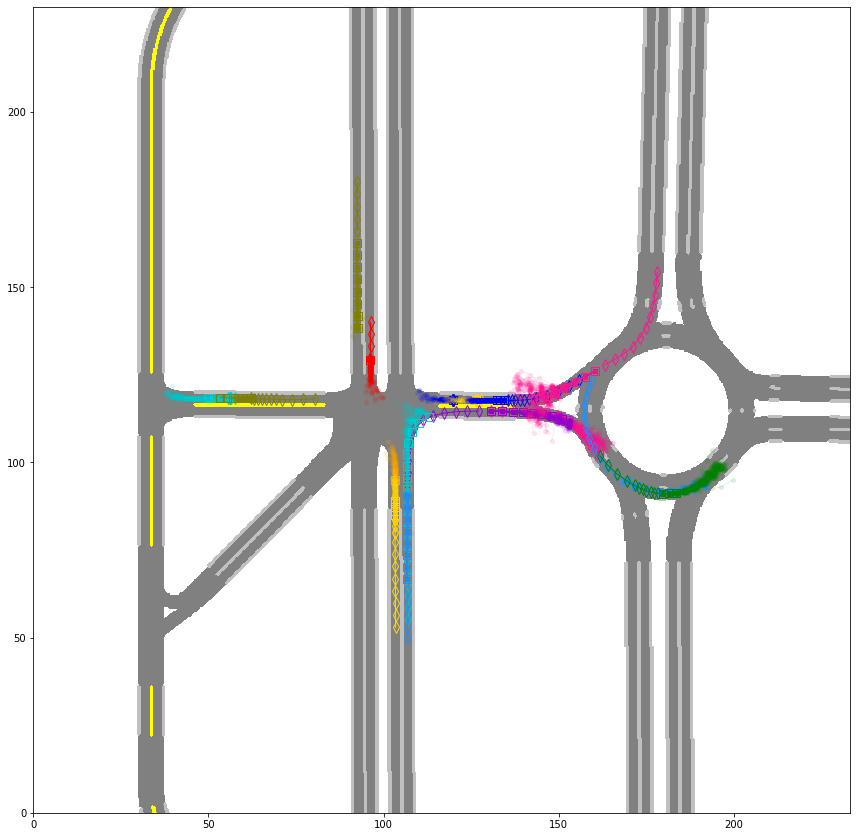

In [39]:
with torch.no_grad():
    # eval_stg the model interface
    predictions = eval_stg.predict(scene,
            timesteps, ph, num_samples=num_samples,
                z_mode=False,
                gmm_mode=False,
                full_dist=False,
                all_z_sep=False)

prediction_dict, histories_dict, futures_dict = \
    prediction_output_to_trajectories(
        predictions, dt=scene.dt, max_h=10, ph=ph, map=None)

v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[timestep].keys()))
v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
node = v_nodes[0]

fig, ax = plt.subplots(figsize=(12,15))
render_roads(ax, scene)

for idx, node in enumerate(v_nodes):
    player_future = futures_dict[timestep][node]
    player_past = histories_dict[timestep][node]
    player_predict = prediction_dict[timestep][node]

    ax.plot(player_future[:,0], player_future[:,1],
                marker='s', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    ax.plot(player_past[:,0], player_past[:,1],
                marker='d', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    for row in player_predict[0]:
        ax.plot(row[:,0], row[:,1],
                marker='o', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, alpha=0.1, markersize=4)

ax.set_xlim([0, scene.x_size])
ax.set_ylim([0, scene.y_size])
fig.tight_layout()
None

Inspect data processing in training

In [40]:
_hyp = copy.deepcopy(hyp)
_hyp['map_encoder']['VEHICLE']['patch_size']

[70, 20, 70, 120]

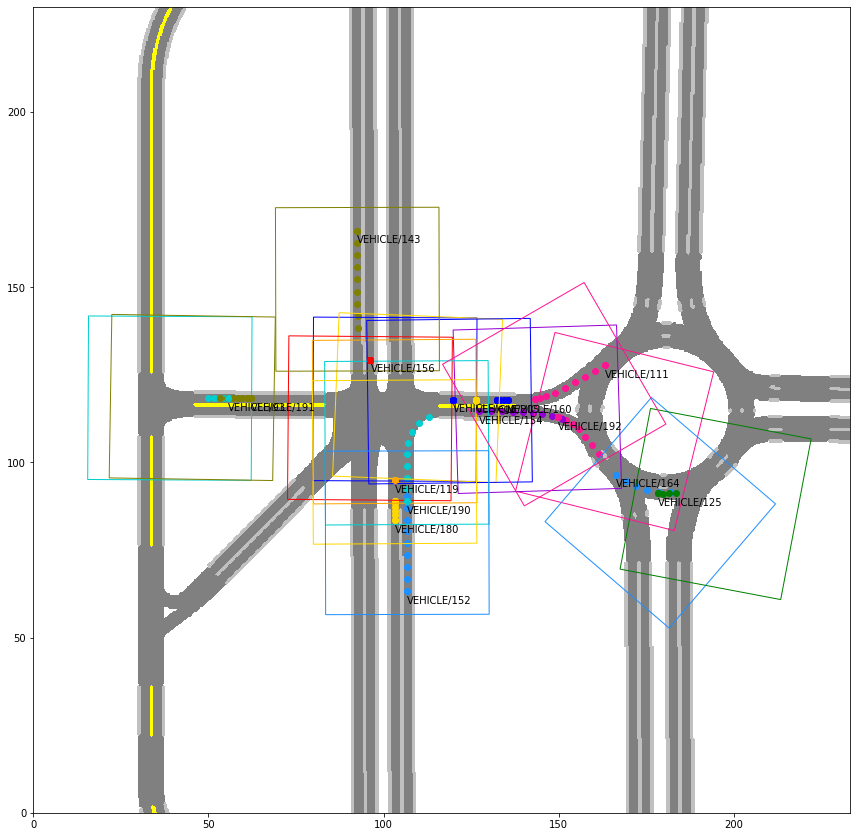

In [41]:
_hyp = copy.deepcopy(hyp)
v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[timestep].keys()))
v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
node = v_nodes[0]

fig, ax = plt.subplots(figsize=(12,15))
render_roads(ax, scene)

alt_patch_size = None
# alt_patch_size = [100, 100, 100, 100]
# alt_patch_size = [70, 20, 70, 120]

for idx, node in enumerate(v_nodes):
    x, y = node.get(np.array([timestep]), {'position': ['x', 'y']}).squeeze()
    ax.plot(x, y, marker='o', color=AGENT_COLORS[idx % NCOLORS])
    
    state = [('position', 'x'), ('position', 'y')]
    gt_range = np.array([timestep, timestep + ph])
    gt = node.get(gt_range, state).T
    
    ax.scatter(gt[0], gt[1], color=AGENT_COLORS[idx % NCOLORS])
    
    state = _hyp['state']
    pred_state = _hyp['pred_state']
    edge_types = eval_env.get_edge_types()
    max_ht = _hyp['maximum_history_length']
    max_ft = _hyp['prediction_horizon']
    _, _, _, _, _, _, _, _, map_tuple \
            = get_node_timestep_data(eval_env, scene, timestep, node, 
                                     state, pred_state, edge_types,
                                     max_ht, max_ft, _hyp)
    scene_map, map_point, heading_angle, patch_size = map_tuple
    # Must divide by 3 due to homography?
    if alt_patch_size:
        min_x, min_y, max_x, max_y = alt_patch_size
    else:
        min_x, min_y, max_x, max_y = patch_size
    # patch_size = [-x, -y, +x, +y] = [50, 10, 50, 90]
    min_x, min_y = -min_x / 3, -min_y / 3
    max_x, max_y = max_x / 3, max_y / 3
    # Must add 90 deg, why?
    mtx = util.rotation_2d(np.deg2rad(heading_angle + 90))
    rect = np.array([
            [max_x, max_y],
            [max_x, min_y],
            [min_x, min_y],
            [min_x, max_y]])
    rect = rect @ mtx.T + map_point
    patch = patches.Polygon(rect, fill=False, color=AGENT_COLORS[idx % NCOLORS])
    ax.add_patch(patch)
    ax.text(x, y - 3.5, str(node))

fig.tight_layout()

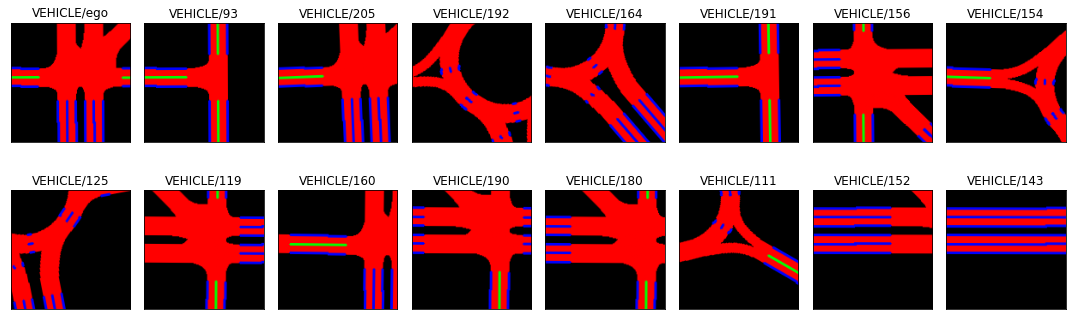

In [11]:
_hyp = copy.deepcopy(hyp)
v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[timestep].keys()))
v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
node = v_nodes[0]

fig, axes = plt.subplots(2, len(v_nodes) // 2 + len(v_nodes) % 2, figsize=(15,5))
axes = axes.ravel()

alt_patch_size = None
# original is [50, 10, 50, 90]
alt_patch_size = [70, 20, 70, 120]

for idx, node in enumerate(v_nodes):
    state = _hyp['state']
    pred_state = _hyp['pred_state']
    edge_types = eval_env.get_edge_types()
    max_ht = _hyp['maximum_history_length']
    max_ft = _hyp['prediction_horizon']
    _, _, _, _, _, _, _, _, map_tuple \
            = get_node_timestep_data(eval_env, scene, timestep, node, 
                                     state, pred_state, edge_types,
                                     max_ht, max_ft, _hyp)
    scene_map, map_point, heading_angle, patch_size = map_tuple
    if alt_patch_size:
        patch_size = alt_patch_size
    cropped_map = scene_map.get_cropped_maps(torch.Tensor([map_point]), patch_size,
                           rotation=torch.Tensor([heading_angle]), device='cpu')
    _cropped_map = cropped_map.squeeze().permute(2,1,0).detach().numpy()
    axes[idx].imshow(_cropped_map, origin='lower')
    axes[idx].set_title(repr(node))
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    

fig.tight_layout()

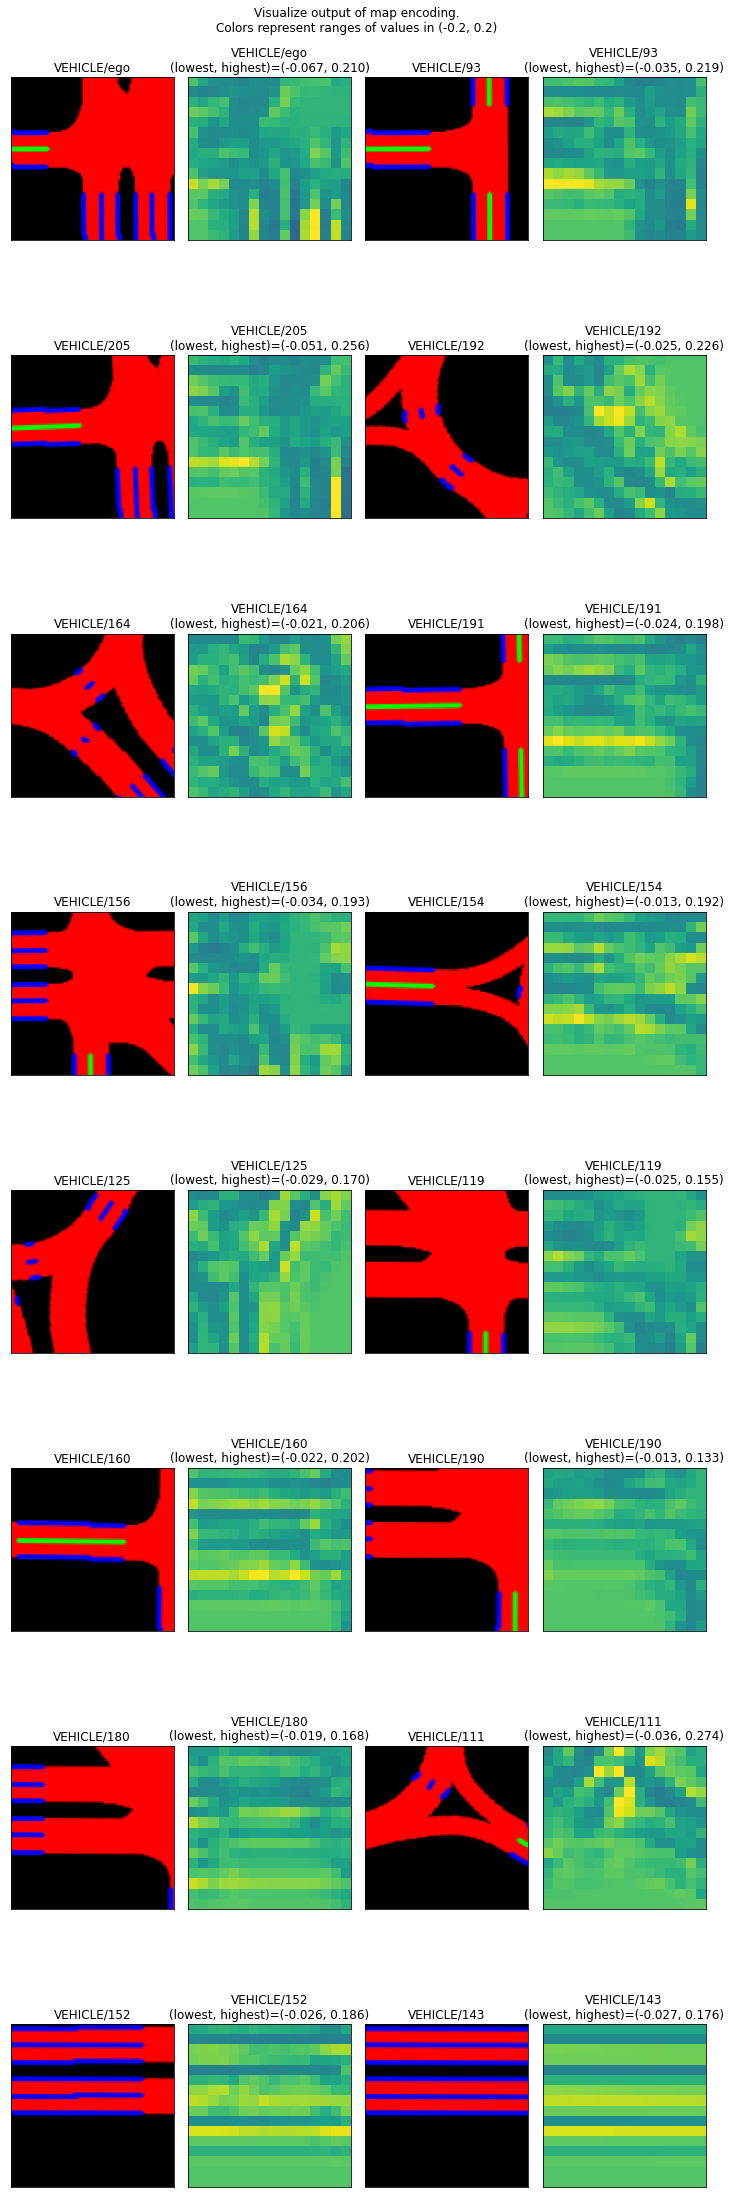

In [14]:
# visualizing the last layer of the CNN network
_hyp = copy.deepcopy(hyp)
eval_model = eval_stg.node_models_dict['VEHICLE']
map_encoder = eval_model.node_modules['VEHICLE/map_encoder']
v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[timestep].keys()))
v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
node = v_nodes[0]

n_windows = 2*len(v_nodes)
fig, axes = plt.subplots((n_windows // 4) + (len(v_nodes) % 4 != 0), 4, figsize=(10,n_windows))
axes = axes.ravel()

vrange = (-0.2, 0.2)

for idx, node in enumerate(v_nodes):
    state = _hyp['state']
    pred_state = _hyp['pred_state']
    edge_types = eval_env.get_edge_types()
    max_ht = _hyp['maximum_history_length']
    max_ft = _hyp['prediction_horizon']
    _, _, _, _, _, _, _, _, map_tuple \
            = get_node_timestep_data(eval_env, scene, timestep, node, 
                                     state, pred_state, edge_types,
                                     max_ht, max_ft, _hyp)
    scene_map, map_point, heading_angle, patch_size = map_tuple
    cropped_map = scene_map.get_cropped_maps(torch.Tensor([map_point]), patch_size,
                           rotation=torch.Tensor([heading_angle]), device='cpu')
    _cropped_map = cropped_map.squeeze().permute(2,1,0).detach().numpy()
    axes[2*idx].imshow(_cropped_map, origin='lower')

    
    x = cropped_map
    for conv in map_encoder.convs:
        x = F.leaky_relu(conv(x), 0.2)
    _map_encoding = x.squeeze().permute(1,0).detach().numpy()
    e_min = _map_encoding.min()
    e_max = _map_encoding.max()
#     print(e_min, e_max)
    axes[2*idx + 1].imshow(_map_encoding, origin='lower', vmin=vrange[0], vmax=vrange[1])
    axes[2*idx].set_title(repr(node))
    title = "{}\n(lowest, highest)=({:1.3f}, {:1.3f})".format(repr(node), e_min, e_max)
    axes[2*idx+1].set_title(title)
    for ax in axes[2*idx : 2*idx + 2]:
        ax.set_xticks([])
        ax.set_yticks([])

for ax in axes[2*idx+2:]:
    fig.delaxes(ax)

fig.suptitle(f"Visualize output of map encoding.\nColors represent ranges of values in ({vrange[0]}, {vrange[1]})")
fig.tight_layout()

Inspect CNNMapEncoder hidden features

VEHICLE/ego
torch.Size([12, 68, 68])
torch.Size([12, 68, 68])
torch.Size([12, 34, 34])
torch.Size([24, 15, 15])
torch.Size([24, 15, 15])


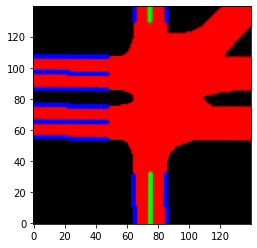

In [83]:
# visualizing the last layer of the CNN network
_hyp = copy.deepcopy(hyp)
eval_model = eval_stg.node_models_dict['VEHICLE']
map_encoder = eval_model.node_modules['VEHICLE/map_encoder']
v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[timestep].keys()))

node = v_nodes[1]
print(node)
state = _hyp['state']
pred_state = _hyp['pred_state']
edge_types = eval_env.get_edge_types()
max_ht = _hyp['maximum_history_length']
max_ft = _hyp['prediction_horizon']
_, _, _, _, _, _, _, _, map_tuple \
        = get_node_timestep_data(eval_env, scene, timestep, node, 
                                 state, pred_state, edge_types,
                                 max_ht, max_ft, _hyp)
scene_map, map_point, heading_angle, patch_size = map_tuple
cropped_map = scene_map.get_cropped_maps(torch.Tensor([map_point]), patch_size,
                       rotation=torch.Tensor([heading_angle]), device='cpu')
_cropped_map = cropped_map.squeeze().permute(1,2,0).detach().numpy()
plt.imshow(_cropped_map, origin='lower')

"""
CNNMapEncoder(
  (convs): ModuleList(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(2, 2))
    (1): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2))
    (2): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1))
    (3): Conv2d(10, 1, kernel_size=(3, 3), stride=(1, 1))
  )
  (fc): Linear(in_features=256, out_features=32, bias=True)
)"""

activation = lambda x: F.leaky_relu(x, 0.2)
# activation = lambda x: F.relu(x)
with torch.no_grad():
    # it's possible to index and get the length of nn.Sequential modules.
    _inter_1 = activation(map_encoder.convs[0](cropped_map))
    # inter_1 has shape (10, 48, 48)
    inter_1 = _inter_1.squeeze(0)
    print(inter_1.shape)

    _inter_2 = activation(map_encoder.convs[1](_inter_1))
    inter_2 = _inter_2.squeeze(0)
    # inter_2 has shape (20, 22, 22)
    print(inter_2.shape)
    
    _inter_3 = activation(map_encoder.convs[2](_inter_2))
    inter_3 = _inter_3.squeeze(0)
    # inter_3 has shape (10, 18, 18)
    print(inter_3.shape)
    
    _inter_4 = activation(map_encoder.convs[3](_inter_3))
    inter_4 = _inter_4.squeeze(0)
    # inter_4 has shape (1, 16, 16)
    print(inter_4.shape)
    
    _inter_5 = activation(map_encoder.convs[4](_inter_4))
    inter_4 = _inter_4.squeeze(0)
    # inter_4 has shape (1, 16, 16)
    print(inter_4.shape)

-0.20976985 1.2595011


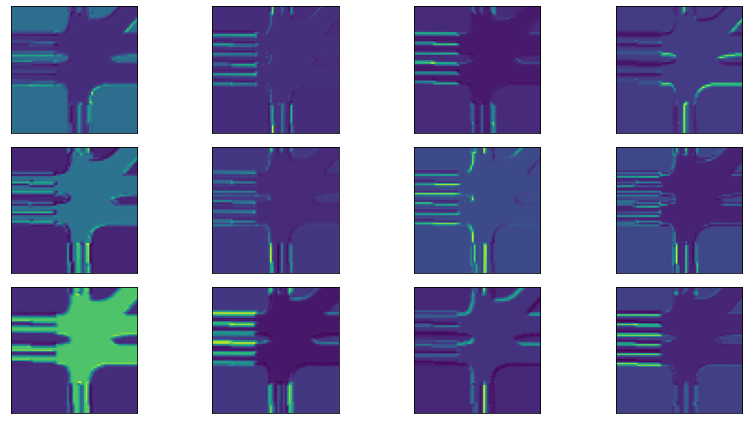

In [62]:
_inter_1 = inter_1.cpu().detach().numpy()

e_min = _inter_1.min()
e_max = _inter_1.max()
print(e_min, e_max)

channels = _inter_1.shape[0]
fig, axes = plt.subplots(channels // 4, 4 + int(channels % 4 > 0), figsize=(12, 6))
axes = axes.ravel()

for i, h in enumerate(_inter_1):
    axes[i].imshow(h, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.tight_layout()

0.0 1.2595011


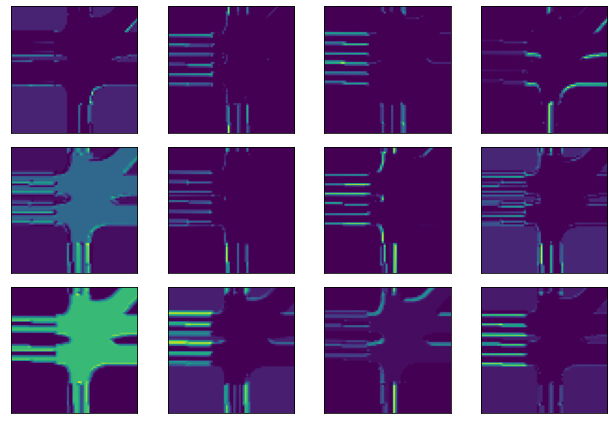

In [84]:
_inter_2 = inter_2.cpu().detach().numpy()

e_min = _inter_2.min()
e_max = _inter_2.max()
print(e_min, e_max)

channels = _inter_2.shape[0]
fig, axes = plt.subplots(channels // 4, 4 + int(channels % 4 > 0), figsize=(9, 6))
axes = axes.ravel()

for i, h in enumerate(_inter_2):
    axes[i].imshow(h, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.tight_layout()

0.0 1.2595011


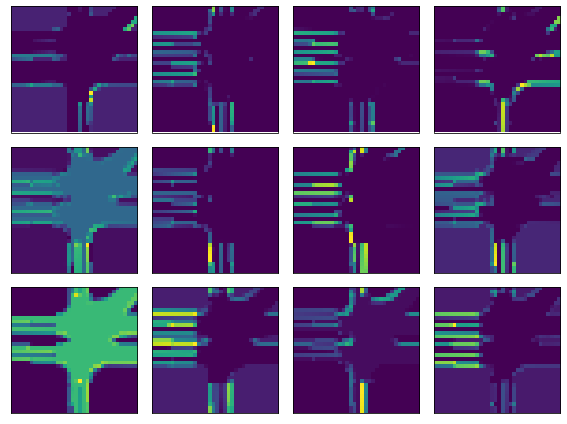

In [56]:
_inter_3 = inter_3.cpu().detach().numpy()

e_min = _inter_3.min()
e_max = _inter_3.max()
print(e_min, e_max)

channels = _inter_3.shape[0]
fig, axes = plt.subplots(channels // 4, 4 + int(channels % 4 > 0), figsize=(8, 6))
axes = axes.ravel()

for i, h in enumerate(_inter_3):
    axes[i].imshow(h, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.tight_layout()

-0.50624895 0.58704126


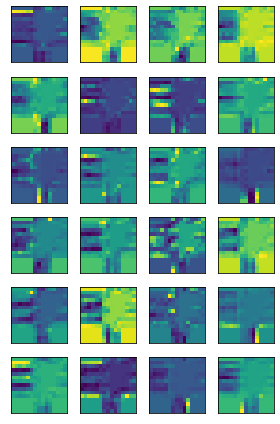

In [69]:
_inter_4 = inter_4.cpu().detach().numpy()

e_min = _inter_4.min()
e_max = _inter_4.max()
print(e_min, e_max)

channels = _inter_4.shape[0]
fig, axes = plt.subplots(channels // 4, 4 + int(channels % 4 > 0), figsize=(4,6))
axes = axes.ravel()

for i, h in enumerate(_inter_4):
    axes[i].imshow(h, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.tight_layout()

In [60]:
channel // 4, 4 + int(channel % 4 > 0)

(3, 4)

Inspect CNNMapEncoderV3 hidden features

In [86]:
map_encoder = eval_stg.model_registrar.model_dict['VEHICLE/map_encoder']
col_names = ("num_params", "kernel_size")
torchinfo.summary(map_encoder, col_names=col_names)

Layer (type:depth-idx)                   Param #                   Kernel Shape
CNNMapEncoderV3                          --                        --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       912                       [3, 12, 5, 5]
│    └─ReLU: 2-2                         --                        --
│    └─MaxPool2d: 2-3                    --                        --
│    └─Conv2d: 2-4                       7,224                     [12, 24, 5, 5]
│    └─ReLU: 2-5                         --                        --
│    └─MaxPool2d: 2-6                    --                        --
│    └─Conv2d: 2-7                       10,416                    [24, 48, 3, 3]
│    └─ReLU: 2-8                         --                        --
│    └─Conv2d: 2-9                       196                       [48, 4, 1, 1]
│    └─Flatten: 2-10                     --                        --
Total params: 18,748
Trainable par

torch.Size([12, 68, 68])
torch.Size([24, 15, 15])
torch.Size([48, 5, 5])
torch.Size([3, 5, 5])


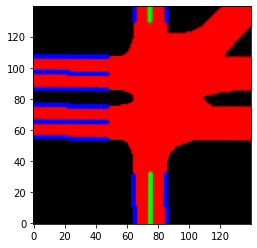

In [72]:
# visualizing the last layer of the CNN network
_hyp = copy.deepcopy(hyp)
eval_model = eval_stg.node_models_dict['VEHICLE']
map_encoder = eval_model.node_modules['VEHICLE/map_encoder']
v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[timestep].keys()))

node = v_nodes[1]
state = _hyp['state']
pred_state = _hyp['pred_state']
edge_types = eval_env.get_edge_types()
max_ht = _hyp['maximum_history_length']
max_ft = _hyp['prediction_horizon']
_, _, _, _, _, _, _, _, map_tuple \
        = get_node_timestep_data(eval_env, scene, timestep, node, 
                                 state, pred_state, edge_types,
                                 max_ht, max_ft, _hyp)
scene_map, map_point, heading_angle, patch_size = map_tuple
cropped_map = scene_map.get_cropped_maps(torch.Tensor([map_point]), patch_size,
                       rotation=torch.Tensor([heading_angle]), device='cpu')
_cropped_map = cropped_map.squeeze().permute(1,2,0).detach().numpy()
plt.imshow(_cropped_map, origin='lower')

with torch.no_grad():
    # it's possible to index and get the length of nn.Sequential modules.
    _inter_1 = map_encoder.convs[0:2](cropped_map) # conv relu
    # inter_1 has shape (12, 68, 68)
    inter_1 = _inter_1.squeeze(0)
    print(inter_1.shape)

    _inter_2 = map_encoder.convs[2:5](_inter_1) # maxpool conv relu
    inter_2 = _inter_2.squeeze(0)
    # inter_2 has shape (24, 15, 15)
    print(inter_2.shape)
    
    _inter_3 = map_encoder.convs[5:8](_inter_2) # maxpool conv relu
    inter_3 = _inter_3.squeeze(0)
    # inter_3 has shape (48, 5, 5)
    print(inter_3.shape)
    
    _inter_4 = map_encoder.convs[8:9](_inter_3) # conv relu
    inter_4 = _inter_4.squeeze(0)
    # inter_4 has shape (3, 5, 5)
    print(inter_4.shape)

0.0 1.9070688


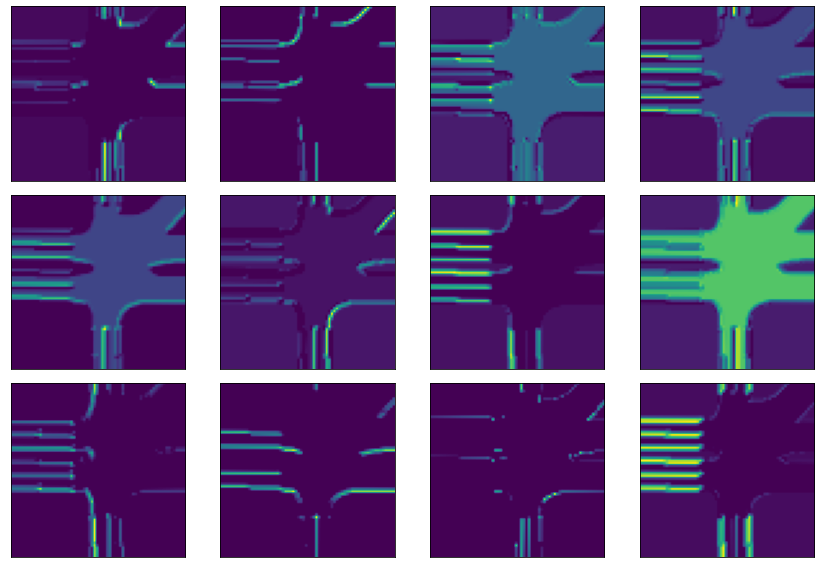

In [73]:
_inter_1 = inter_1.cpu().detach().numpy()

e_min = _inter_1.min()
e_max = _inter_1.max()
print(e_min, e_max)

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
axes = axes.ravel()

for i, h in enumerate(_inter_1):
    axes[i].imshow(h, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.tight_layout()

0.0 1.0461898


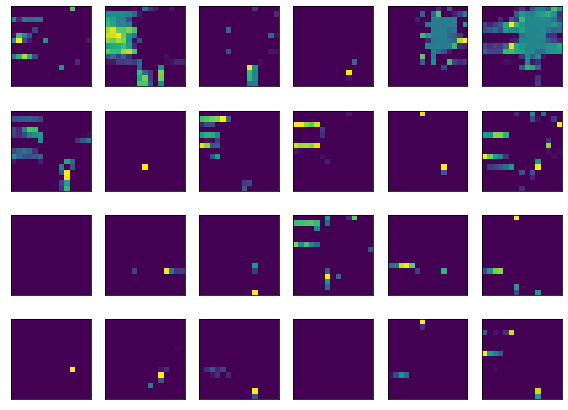

In [74]:
_inter_2 = inter_2.cpu().detach().numpy()

e_min = _inter_2.min()
e_max = _inter_2.max()
print(e_min, e_max)

fig, axes = plt.subplots(4, 6, figsize=(8, 6))
axes = axes.ravel()

for i, h in enumerate(_inter_2):
    axes[i].imshow(h, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.tight_layout()

0.0 1.535961


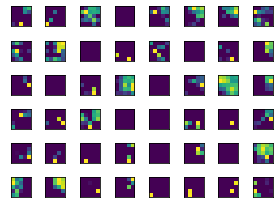

In [75]:
_inter_3 = inter_3.cpu().detach().numpy()

e_min = _inter_3.min()
e_max = _inter_3.max()
print(e_min, e_max)

fig, axes = plt.subplots(6, 8, figsize=(4, 3))
axes = axes.ravel()

for i, h in enumerate(_inter_3):
    axes[i].imshow(h, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.tight_layout()

-0.30267328 0.059378874


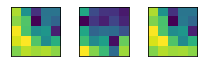

In [76]:
_inter_4 = inter_4.cpu().detach().numpy()

e_min = _inter_4.min()
e_max = _inter_4.max()
print(e_min, e_max)

fig, axes = plt.subplots(1, 3, figsize=(3, 1))
axes = axes.ravel()

for i, h in enumerate(_inter_4):
    axes[i].imshow(h, origin='lower')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.tight_layout()

Look at what the CNN encoder looks like, and modify it

In [15]:
class OldCNNMapEncoder(nn.Module):
    def __init__(self, map_channels, hidden_channels, output_size, masks, strides, patch_size):
        super(OldCNNMapEncoder, self).__init__()
        self.convs = nn.ModuleList()
        patch_size_x = patch_size[0] + patch_size[2]
        patch_size_y = patch_size[1] + patch_size[3]
        input_size = (map_channels, patch_size_x, patch_size_y)
        x_dummy = torch.ones(input_size).unsqueeze(0) * torch.tensor(float('nan'))

        for i, hidden_size in enumerate(hidden_channels):
            self.convs.append(nn.Conv2d(map_channels if i == 0 else hidden_channels[i-1],
                                        hidden_channels[i], masks[i],
                                        stride=strides[i]))
            x_dummy = self.convs[i](x_dummy)

        self.fc = nn.Linear(x_dummy.numel(), output_size)

    def forward(self, x, training):
        for conv in self.convs:
            x = F.leaky_relu(conv(x), 0.2)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [69]:
class CNNMapEncoderV2(nn.Module):
    def __init__(self, config):
        super().__init__()
        patch_size = config['patch_size']
        self.patch_size = (
                patch_size[0] + patch_size[2],
                patch_size[1] + patch_size[3],)
        self.image_channels  = config['map_channels']
        self.hidden_channels = config['hidden_channels']
        self.output_size     = config['output_size']
        self.filters         = config['masks']
        try:
            self.strides  = config['strides']
        except:
            self.strides  = [1 for _ in self.filters]
        try:
            self.paddings = config['paddings']
        except:
            self.paddings = [0 for _ in self.filters]
        try:
            self.poolings = config['poolings']
        except:
            self.poolings = [None for _ in self.filters]
        if 'fc_features' in config:
            self.fc_features     = config.fc_features
        else:
            self.fc_features = []
        dummy = torch.ones((self.image_channels, *self.patch_size,)).unsqueeze(0) \
                * torch.tensor(float('nan'))
        conv_layers = []
        _channels = util.pairwise((self.image_channels, *self.hidden_channels,))
        for idx, ((_in_channel, _out_channel), _filter, _stride, _padding, _pool) in enumerate(
                zip(_channels, self.filters, self.strides, self.paddings, self.poolings)):
            conv = nn.Conv2d(_in_channel, _out_channel, _filter, stride=_stride, padding=_padding)
            conv_layers.append(conv)
            conv_layers.append(nn.ReLU())
            if _pool == 'max':
                pool = nn.MaxPool2d(2, 2)
                conv_layers.append(pool)
            elif _pool is None:
                pass
        self.convs = nn.Sequential(*conv_layers)
        dummy = self.convs(dummy)
        self.fc_inputs = dummy.numel()
        _features = util.pairwise((self.fc_inputs, *self.fc_features, self.output_size))
        fc_layers = []
        for idx, (_in_features, _out_features) in enumerate(_features):
            fc = nn.Linear(_in_features, _out_features)
            fc_layers.append(fc)
            fc_layers.append(nn.ReLU())
        self.fcs = nn.Sequential(*fc_layers)

    def forward(self, x, training):
        x = self.convs(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fcs(x)
        return x

In [78]:
class CNNMapEncoderV3(nn.Module):
    def __init__(self, config):
        super().__init__()
        patch_size = config['patch_size']
        self.patch_size = (
                patch_size[0] + patch_size[2],
                patch_size[1] + patch_size[3],)
        self.image_channels  = config['map_channels']
        self.hidden_channels = config['hidden_channels']
        self.filters         = config['masks']
        self.output_size     = config['output_size']
        try:
            self.strides  = config['strides']
        except:
            self.strides  = [1 for _ in self.filters]
        try:
            self.paddings = config['paddings']
        except:
            self.paddings = [0 for _ in self.filters]
        try:
            self.poolings = config['poolings']
        except:
            self.poolings = [None for _ in self.filters]
        self.apply_last_cnn_activation = ('apply_last_cnn_activation' not in config) \
                or config['apply_last_cnn_activation']
        conv_layers = []
        _channels = util.pairwise((self.image_channels, *self.hidden_channels,))
        for idx, ((_in_channel, _out_channel), _filter, _stride, _padding, _pool) in enumerate(
                zip(_channels, self.filters, self.strides, self.paddings, self.poolings)):
            conv = nn.Conv2d(_in_channel, _out_channel, _filter, stride=_stride, padding=_padding)
            conv_layers.append(conv)
            if idx != len(_channels) - 1 or self.apply_last_cnn_activation:
                conv_layers.append(nn.ReLU())
            if _pool == 'max':
                pool = nn.MaxPool2d(2, 2)
                conv_layers.append(pool)
            elif _pool is None:
                pass
        conv_layers.append(nn.Flatten())
        self.convs = nn.Sequential(*conv_layers)
        dummy = torch.ones((self.image_channels, *self.patch_size,)).unsqueeze(0) \
                * torch.tensor(float('nan'))
        dummy = self.convs(dummy)
        self.has_fc = ('has_fc' not in config) or config['has_fc']
        if self.has_fc:
            # Add the FC layers after the CNN layers
            if 'fc_features' in config:
                self.fc_features     = config.fc_features
            else:
                self.fc_features = []
            self.apply_last_fc_activation = ('apply_last_fc_activation' not in config) \
                    or config['apply_last_fc_activation']
            self.fc_inputs = dummy.numel()
            _features = util.pairwise((self.fc_inputs, *self.fc_features, self.output_size))
            fc_layers = []
            for idx, (_in_features, _out_features) in enumerate(_features):
                fc = nn.Linear(_in_features, _out_features)
                fc_layers.append(fc)
                if idx != len(_features) - 1 or self.apply_last_fc_activation:
                    fc_layers.append(nn.ReLU())
            self.fcs = nn.Sequential(*fc_layers)
        else:
            assert self.output_size == dummy.numel()

    def forward(self, x, training):
        x = self.convs(x)
        if self.has_fc:
            x = self.fcs(x)
        return x

In [48]:
me_params = util.AttrDict(**{
    "heading_state_index": 6,
    "patch_size": [50, 10, 50, 90],
    "map_channels": 3,
    "hidden_channels": [10, 20, 10, 1],
    "output_size": 32,
    "masks": [5, 5, 5, 3],
    "strides": [2, 2, 1, 1],
    "dropout": 0.5
})
map_encoder = OldCNNMapEncoder(map_channels=me_params.map_channels,
                            hidden_channels=me_params.hidden_channels,
                            output_size=me_params.output_size,
                            masks=me_params.masks,
                            strides=me_params.strides,
                            patch_size=me_params.patch_size)

# Original CNNMapEncoder
# Parameters: 19,105.
col_names = ("input_size", "output_size", "num_params", "kernel_size")#, "mult_adds",)
torchinfo.summary(map_encoder, input_size=(1, 3, 100, 100), col_names=col_names, col_width=18, training=True)

Layer (type:depth-idx)                   Input Shape        Output Shape       Param #            Kernel Shape
OldCNNMapEncoder                         --                 --                 --                 --
├─ModuleList: 1-1                        --                 --                 --                 --
│    └─Conv2d: 2-1                       [1, 3, 100, 100]   [1, 10, 48, 48]    760                [3, 10, 5, 5]
│    └─Conv2d: 2-2                       [1, 10, 48, 48]    [1, 20, 22, 22]    5,020              [10, 20, 5, 5]
│    └─Conv2d: 2-3                       [1, 20, 22, 22]    [1, 10, 18, 18]    5,010              [20, 10, 5, 5]
│    └─Conv2d: 2-4                       [1, 10, 18, 18]    [1, 1, 16, 16]     91                 [10, 1, 3, 3]
├─Linear: 1-2                            [1, 256]           [1, 32]            8,224              [256, 32]
Total params: 19,105
Trainable params: 19,105
Non-trainable params: 0
Total mult-adds (M): 5.84
Input size (MB): 0.12
Forward/bac

In [103]:
me_params = util.AttrDict(**{
    "heading_state_index": 6,
    "patch_size": [70, 20, 70, 120],
    "map_channels": 3,
    "hidden_channels": [12, 24, 48],
    "output_size": 32,
    "masks": [5, 5, 3],
    "strides": [2, 2, 1],
    "poolings": ['max', 'max', None],
    "apply_last_fc_activation": False,
})

map_encoder = CNNMapEncoderV3(me_params)
# CNNMapEncoderV3
# Parameters: 56,984
col_names = ("input_size", "output_size", "num_params", "kernel_size")#, "mult_adds",)
torchinfo.summary(map_encoder, input_size=(1, 3, 140, 140), col_names=col_names, col_width=18, training=True)

Layer (type:depth-idx)                   Input Shape        Output Shape       Param #            Kernel Shape
CNNMapEncoderV3                          --                 --                 --                 --
├─Sequential: 1-1                        [1, 3, 140, 140]   [1, 1200]          --                 --
│    └─Conv2d: 2-1                       [1, 3, 140, 140]   [1, 12, 68, 68]    912                [3, 12, 5, 5]
│    └─ReLU: 2-2                         [1, 12, 68, 68]    [1, 12, 68, 68]    --                 --
│    └─MaxPool2d: 2-3                    [1, 12, 68, 68]    [1, 12, 34, 34]    --                 --
│    └─Conv2d: 2-4                       [1, 12, 34, 34]    [1, 24, 15, 15]    7,224              [12, 24, 5, 5]
│    └─ReLU: 2-5                         [1, 24, 15, 15]    [1, 24, 15, 15]    --                 --
│    └─MaxPool2d: 2-6                    [1, 24, 15, 15]    [1, 24, 7, 7]      --                 --
│    └─Conv2d: 2-7                       [1, 24, 7, 7]    

In [102]:
me_params = util.AttrDict(**{
    "heading_state_index": 6,
    "patch_size": [70, 20, 70, 120],
    "map_channels": 3,
    "output_size": 75,
    "hidden_channels": [12, 24, 48, 3],
    "masks": [5, 5, 3, 1],
    "strides": [2, 2, 1, 1],
    "poolings": ['max', 'max', None, None],
    "apply_last_cnn_activation": False,
    "has_fc": False
})
map_encoder = CNNMapEncoderV3(me_params)
# CNNMapEncoderV3
# Parameters: 56,984
col_names = ("input_size", "output_size", "num_params", "kernel_size")#, "mult_adds",)
torchinfo.summary(map_encoder, input_size=(1, 3, 140, 140), col_names=col_names, col_width=18, training=True)

Layer (type:depth-idx)                   Input Shape        Output Shape       Param #            Kernel Shape
CNNMapEncoderV3                          --                 --                 --                 --
├─Sequential: 1-1                        [1, 3, 140, 140]   [1, 75]            --                 --
│    └─Conv2d: 2-1                       [1, 3, 140, 140]   [1, 12, 68, 68]    912                [3, 12, 5, 5]
│    └─ReLU: 2-2                         [1, 12, 68, 68]    [1, 12, 68, 68]    --                 --
│    └─MaxPool2d: 2-3                    [1, 12, 68, 68]    [1, 12, 34, 34]    --                 --
│    └─Conv2d: 2-4                       [1, 12, 34, 34]    [1, 24, 15, 15]    7,224              [12, 24, 5, 5]
│    └─ReLU: 2-5                         [1, 24, 15, 15]    [1, 24, 15, 15]    --                 --
│    └─MaxPool2d: 2-6                    [1, 24, 15, 15]    [1, 24, 7, 7]      --                 --
│    └─Conv2d: 2-7                       [1, 24, 7, 7]    

Look at what the full model looks like

In [12]:
print(eval_stg.model_registrar)
col_names = ("num_params", "kernel_size")
torchinfo.summary(eval_stg.model_registrar.model_dict, col_names=col_names)

ModelRegistrar(
  (model_dict): ModuleDict(
    (VEHICLE/node_history_encoder): LSTM(10, 32, batch_first=True)
    (VEHICLE/node_future_encoder): LSTM(2, 32, batch_first=True, bidirectional=True)
    (VEHICLE/node_future_encoder/initial_h): Linear(in_features=10, out_features=32, bias=True)
    (VEHICLE/node_future_encoder/initial_c): Linear(in_features=10, out_features=32, bias=True)
    (VEHICLE/edge_influence_encoder): AdditiveAttention(
      (w1): Linear(in_features=32, out_features=32, bias=False)
      (w2): Linear(in_features=32, out_features=32, bias=False)
      (v): Linear(in_features=32, out_features=1, bias=False)
    )
    (VEHICLE/map_encoder): CNNMapEncoderV3(
      (convs): Sequential(
        (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2))
        (4): ReLU()
        (5): MaxPool2d(kernel_size=

Layer (type:depth-idx)                   Param #                   Kernel Shape
ModuleDict                               --                        --
├─LSTM: 1-1                              5,632                     --
├─LSTM: 1-2                              9,216                     --
├─Linear: 1-3                            352                       [10, 32]
├─Linear: 1-4                            352                       [10, 32]
├─AdditiveAttention: 1-5                 --                        --
│    └─Linear: 2-1                       1,024                     [32, 32]
│    └─Linear: 2-2                       1,024                     [32, 32]
│    └─Linear: 2-3                       32                        [32, 1]
├─CNNMapEncoderV3: 1-6                   --                        --
│    └─Sequential: 2-4                   --                        --
│    │    └─Conv2d: 3-1                  912                       [3, 12, 5, 5]
│    │    └─ReLU: 3-2                   

## Scratch work

In [209]:
present_nodes = scene.present_nodes(timesteps, type='VEHICLE')
node = present_nodes[timestep][1]
print( str(node) )
node.data.data.shape, node.data.header, node.data.double_header_lookup

VEHICLE/2092


((25, 12),
 [('position', 'x'),
  ('position', 'y'),
  ('velocity', 'x'),
  ('velocity', 'y'),
  ('acceleration', 'x'),
  ('acceleration', 'y'),
  ('heading', 'x'),
  ('heading', 'y'),
  ('heading', '°'),
  ('heading', 'd°'),
  ('velocity', 'norm'),
  ('acceleration', 'norm')],
 OrderedDict([(('position', 'x'), 0),
              (('position', 'y'), 1),
              (('velocity', 'x'), 2),
              (('velocity', 'y'), 3),
              (('acceleration', 'x'), 4),
              (('acceleration', 'y'), 5),
              (('heading', 'x'), 6),
              (('heading', 'y'), 7),
              (('heading', '°'), 8),
              (('heading', 'd°'), 9),
              (('velocity', 'norm'), 10),
              (('acceleration', 'norm'), 11)]))

In [95]:
hyp['map_encoder']['VEHICLE']['heading_state_index'], hyp['state']['VEHICLE']

(6,
 {'position': ['x', 'y'],
  'velocity': ['x', 'y'],
  'acceleration': ['x', 'y'],
  'heading': ['°', 'd°', 'x', 'y']})

In [72]:
present_nodes = scene.present_nodes(timesteps, type='VEHICLE')
node = present_nodes[timestep][1]
print( str(node) )

_hyp = copy.deepcopy(hyp)
# _hyp['map_encoder']['VEHICLE']['patch_size'] = [50, 50, 50, 50]
# _hyp['map_encoder']['VEHICLE']['heading_state_index'] = 6
state = _hyp['state']
pred_state = _hyp['pred_state']
edge_types = eval_env.get_edge_types()
max_ht = _hyp['maximum_history_length']
max_ft = _hyp['prediction_horizon']
print(max_ht, max_ft)
print("traj input size per t:",  len( util.merge_list_of_list(state['VEHICLE'].values()) )  )
print("output size per t:",  len( util.merge_list_of_list(pred_state['VEHICLE'].values()) )  )

# x_t is past at time t, y_t is gt at time t
first_history_index, x_t, y_t, x_st_t, y_st_t, neighbors_data_st, \
        neighbors_edge_value, robot_traj_st_t, map_tuple \
            = get_node_timestep_data(eval_env, scene, timestep, node, 
                                     state, pred_state, edge_types, max_ht, max_ft, _hyp)

# x_t is extracted using ode.get() on timesteps, state
print('node.get', node.get(timesteps, state['VEHICLE']))
print('x_t', x_t[-1])

scene_map, map_point, heading_angle, patch_size = map_tuple
print("map_point", map_point)
print("heading_angle", heading_angle)
print("patch_size", patch_size)

VEHICLE/ego
8 8
traj input size per t: 10
output size per t: 2
node.get [[ 1.13866201e+02  7.31723785e+01  3.86052132e-02 -6.02557373e+00
  -9.07850266e-03  1.39154053e+00  4.71878736e+00  9.32106381e-07
   6.39833402e-03 -9.99979530e-01]]
x_t tensor([ 1.1387e+02,  7.3172e+01,  3.8605e-02, -6.0256e+00, -9.0785e-03,
         1.3915e+00,  4.7188e+00,  9.3211e-07,  6.3983e-03, -9.9998e-01])
map_point [113.86620092  73.17237854] <class 'numpy.ndarray'>
heading_angle -270.3666000366211
patch_size [50, 10, 50, 90]


VEHICLE/ego


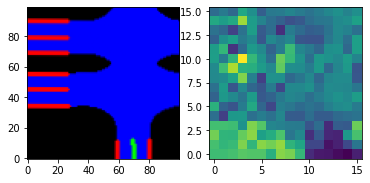

In [58]:
present_nodes = scene.present_nodes(timesteps, type='VEHICLE')
node = present_nodes[timestep][1]
print( str(node) )

_hyp = copy.deepcopy(hyp)
# _hyp['map_encoder']['VEHICLE']['patch_size'] = [50, 50, 50, 50]
# _hyp['map_encoder']['VEHICLE']['heading_state_index'] = 6
state = _hyp['state']
pred_state = _hyp['pred_state']
edge_types = eval_env.get_edge_types()
max_ht = _hyp['maximum_history_length']
max_ft = _hyp['prediction_horizon']

# x_t is past at time t, y_t is gt at time t
first_history_index, x_t, y_t, x_st_t, y_st_t, neighbors_data_st, \
        neighbors_edge_value, robot_traj_st_t, map_tuple \
            = get_node_timestep_data(eval_env, scene, timestep, node, 
                                     state, pred_state, edge_types, max_ht, max_ft, _hyp)

scene_map, map_point, heading_angle, patch_size = map_tuple

cropped_map = scene_map.get_cropped_maps(torch.Tensor([map_point]), patch_size,
                           rotation=torch.Tensor([heading_angle]), device='cpu')

eval_model = eval_stg.node_models_dict['VEHICLE']
map_encoder = eval_model.node_modules['VEHICLE/map_encoder']

_cropped_map = cropped_map.squeeze().permute(2,1,0).detach().numpy()

fig, axes = plt.subplots(1, 2)
axes[0].imshow(_cropped_map, origin='lower')

x = cropped_map
for idx, conv in enumerate(map_encoder.convs):
    x = F.leaky_relu(conv(x), 0.2)

_map_encoding = x.squeeze().permute(1,0).detach().numpy()    
axes[1].imshow(_map_encoding, origin='lower')
None